

## Temperature Forecasting using RNNs

In this notebook, we will work on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

Until now, the only sequence data we have covered has been text data, for instance the IMDb dataset. But sequence
data is found in many more problems than just language processing. In this notebook, we will be playing with a weather timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded every 10 minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the temperature 24 hours in the future.

## Importing the dataset

Let's import the weather dataset and take a look at the data.

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive.

Mounted at /content/drive


Add the `weather.csv` dataset from [here](https://drive.google.com/drive/folders/1-c4CIfRkVYns7p-6InfZxk1NHX-xMLHr) to your Google Drive. For example, you can drag and drop it into your "My Drive".

In [ ]:
# Define the directory where the "weather.csv" file resides on your google drive
# My path is the following (your path will be different):
fname = '/content/drive/My Drive/Data/RNN_Datasets/weather.csv'

Run the code block below to read the data and seperate header from numeric data lines.

In [ ]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')     # Each line is 1 recording
header = lines[0].split(',') # Variable names are separated by commas
lines = lines[1:]            # Drop first line (it's a header)

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Let's convert all of these 420,551 lines of data into a Numpy array:

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)
# Note that we discard the first column (Date Time) as it is not used for prediction

(420551, 14)


For instance, here is the plot of temperature (in degrees Celsius) over time:

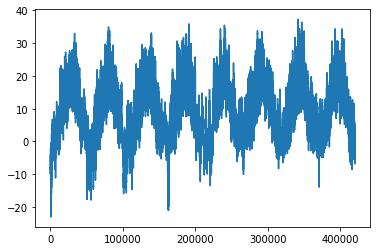

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)


On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points per day or 1440 data points per 10 days):

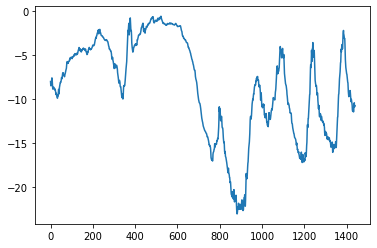

In [ ]:
plt.plot(range(1440), temp[:1440])


On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-day period must be coming from a fairly cold winter month (0 Celsius = 32 Fahrenheit).

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is this timeseries predictable at a daily scale? Let's find out.

## Preparing the data

The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 1440`, i.e. our observations will go back 10 days.
* `steps = 6`, i.e. our observations will be sampled at one data point per hour. (i.e., out of the 6 measurements done during an hour, we keep the first one and throw away the next 5 data points)
* `delay = 144`, i.e. our targets will be 24 hours in the future. (i.e., we want to predict the tempreture of 24 hours later.)

To get started, we need to do two things:

1. Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any vectorization. However each column in the data is on a different scale (e.g. temperature is typically between -20 and +30, but pressure, measured in mbar, is around 1000). So we will normalize each column (feature) independently so that they all take small values on a similar scale.

2. Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a
target temperature in the future. Since the samples in our dataset are highly redundant (e.g. measurement `N` and measurement `N + 1` will have most
of their values in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the
fly using the original data.

We preprocess the data by subtracting the mean of each column (feature) and dividing by the standard deviation. We are going to use the first
200,000 timesteps as training data, so we compute the mean and standard deviation **only on this fraction of the data.** This is because in the real world we do not have access to the full test data in advance; data points come one by one and we have to make predictions as they come. **Therefore, we should only use the mean and standard deviation of the training data to normalize the validation and test data.**

In [ ]:
# Normalizing the Data

mean = float_data[:200000].mean(axis=0)
float_data -= mean
# The above line is equivalent to: float_data = float_data - mean
std = float_data[:200000].std(axis=0)
float_data /= std
# The above line is equivalent to: float_data = float_data / std
# Note: in Python and many other programming langugages x -= c means x = x - c
# and, similarly, x /= c means x = x / c

In [ ]:
# Let's look at the temperature standard deviation as we will need it layer
# pressure is index 0 and tempreture is index 1 in our dataset
print(std[1])

8.85249908220462



Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment
of the data for validation and another one for testing.
* `random_sample`: Whether to randomly sample a point in time between `min_index` and `max_index` or draw samples in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it to 6 in order to draw one data point every hour. (recall that the timestep is 10 minutes, so we have 6 data points every hour)

In [ ]:
import numpy as np

def generator(data, lookback, delay, min_index, max_index, random_sample, batch_size, step, target_index):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    # Out dara generator will generate data indefinitely, so we will have to tell Keras
    # how many batches constitute an epoch ('steps_per_epoch' and 'validation_steps' in model.fit)
    while 1:
        # For the training set (random_sample=True), randomly choose points in time
        if random_sample:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        # For the validation and test sets, choose batches of timesteps (in chronological order)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),       # Batch size
                           lookback // step, # Floor division (e.g., 5//2=2)
                           data.shape[-1]))  # Number of columns in data
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_index]
        yield samples, targets


Now let's use our generator function to instantiate three generators, one for training, one for validation and one for testing.
Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the
validation generator looks at the following 100,000, and the test generator looks at the remainder.

**Note:**  `target_index` refers to the column index in your dataset that corresponds to the target you want to predict.


In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
target_index = 1

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      random_sample=True,
                      step=step,
                      batch_size=batch_size,
                      target_index=target_index)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    random_sample=False,
                    step=step,
                    batch_size=batch_size,
                    target_index=target_index)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     random_sample=False,
                     step=step,
                     batch_size=batch_size,
                     target_index=target_index)


# This is how many batches to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many batches to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

print(val_steps)
print(test_steps)

769
930


## A basic MLP

It is useful to try simple deep learning models (such as small densely-connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate and delivers real benefits.

Here is a simple fully-connected neural network in which we start by flattening the data, then run it through two `Dense` layers. Note the lack of
activation function on the last `Dense` layer, which is typical for a **regression** problem. We use MSE (Mean Square Error) as the loss function here. Please refer to the large table we had in Module 1 to ensure that you use the correct activation function (for the output layer) and loss function based on the problem at hand.
Here, we are going to follow the MAE (mean absolute error) metric over the training process.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model1 = models.Sequential()
model1.add(layers.Flatten(input_shape=(lookback // step, 14)))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(1))

model1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model1_history = model1.fit(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 12s 23ms/step - loss: 3.3089 - mae: 1.0418 - val_loss: 0.2414 - val_mae: 0.3878
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.5320 - mae: 0.5199 - val_loss: 0.1786 - val_mae: 0.3374
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.1858 - mae: 0.3325 - val_loss: 0.1505 - val_mae: 0.3051
Epoch 4/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1287 - mae: 0.2818 - val_loss: 0.1550 - val_mae: 0.3087
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.1091 - mae: 0.2599 - val_loss: 0.1555 - val_mae: 0.3099
Epoch 6/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1000 - mae: 0.2482 - val_loss: 0.1770 - val_mae: 0.3324
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.0924 - mae: 0.2394 - val_loss: 0.1633 - val_mae: 0.3185
Epoch 8/20
500/500 [==============================] - 12s 23ms

Let's display the loss curves for validation and training:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


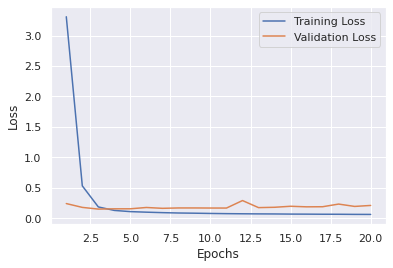

In [ ]:
import seaborn as sns
sns.set()

train_loss1 = model1_history.history['loss']
train_mae1 = model1_history.history['mae']
val_loss1 = model1_history.history['val_loss']
val_mae1 = model1_history.history['val_mae']

epochs = range(1, len(train_loss1) + 1)

plt.plot(epochs, train_loss1, label = 'Training Loss')
plt.plot(epochs, val_loss1, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Because the training loss in the first few epochs is very high, the graph is zoomed out and we cannot see the pattern in later periods well. So, I am going to restric the plot to epochs 5 and beyond.

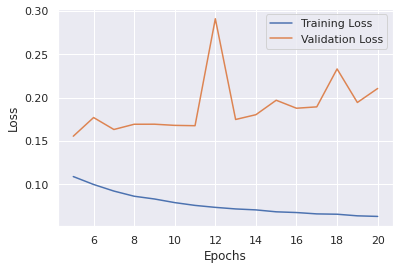

In [ ]:
import seaborn as sns
sns.set()

train_loss1 = model1_history.history['loss']
train_mae1 = model1_history.history['mae']
val_loss1 = model1_history.history['val_loss']
val_mae1 = model1_history.history['val_mae']

epochs = range(1, len(train_loss1) + 1)

plt.plot(epochs[4:], train_loss1[4:], label = 'Training Loss')
plt.plot(epochs[4:], val_loss1[4:], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

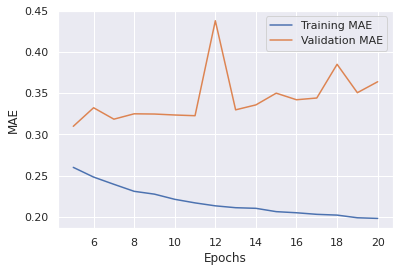

In [ ]:
plt.plot(epochs[4:], train_mae1[4:], label = 'Training MAE')
plt.plot(epochs[4:], val_mae1[4:], label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

Let's evaluate our model1 on the test set.

In [ ]:
model1.evaluate(test_gen, steps=test_steps)

930/930 [==============================] - 9s 10ms/step - loss: 77.1051 - mae: 1.1304


[77.10511016845703, 1.1303670406341553]

The Mean Absolute Error metric (MAE) is 1.13. Recall that MAE is simply equal to `mean(abs(predictions - targets))`.
Since our temperature data have been normalized to be centered on 0 and have a standard deviation of one, this
number is not immediately interpretable. It translates to an average absolute error of `1.13 * temperature_std` degrees Celsius, i.e. 1.13 * 8.85 = 10.0˚C.  
Now the game is to leverage our knowledge of deep learning to do better.

## An LSTM recurrent model

The approach above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data as what it is: a sequence, where the order matters.

Now, we will try an LSTM recurrent model -- it should be the perfect fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike MLP (our first approach).


In [ ]:
model2 = models.Sequential()
model2.add(layers.LSTM(32, input_shape=(lookback // step, 14)))
model2.add(layers.Dense(1))

model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model2_history = model2.fit(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 18s 36ms/step - loss: 0.1491 - mae: 0.3004 - val_loss: 0.1200 - val_mae: 0.2693
Epoch 2/20
500/500 [==============================] - 17s 35ms/step - loss: 0.1193 - mae: 0.2710 - val_loss: 0.1258 - val_mae: 0.2781
Epoch 3/20
500/500 [==============================] - 18s 35ms/step - loss: 0.1072 - mae: 0.2577 - val_loss: 0.1270 - val_mae: 0.2815
Epoch 4/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0985 - mae: 0.2469 - val_loss: 0.1412 - val_mae: 0.2952
Epoch 5/20
500/500 [==============================] - 17s 35ms/step - loss: 0.0917 - mae: 0.2380 - val_loss: 0.1435 - val_mae: 0.2978
Epoch 6/20
500/500 [==============================] - 17s 35ms/step - loss: 0.0856 - mae: 0.2296 - val_loss: 0.1447 - val_mae: 0.2993
Epoch 7/20
500/500 [==============================] - 17s 35ms/step - loss: 0.0796 - mae: 0.2208 - val_loss: 0.1555 - val_mae: 0.3105
Epoch 8/20
500/500 [==============================] - 17s 35ms

Let look at our results:

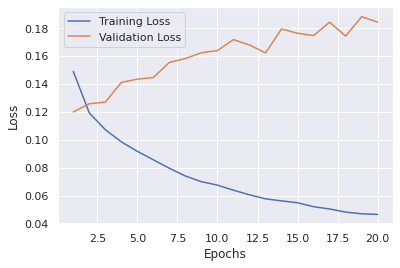

In [ ]:
import seaborn as sns
sns.set()

train_loss2 = model2_history.history['loss']
train_mae2 = model2_history.history['mae']
val_loss2 = model2_history.history['val_loss']
val_mae2 = model2_history.history['val_mae']

epochs = range(1, len(train_loss2) + 1)

plt.plot(epochs, train_loss2, label = 'Training Loss')
plt.plot(epochs, val_loss2, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

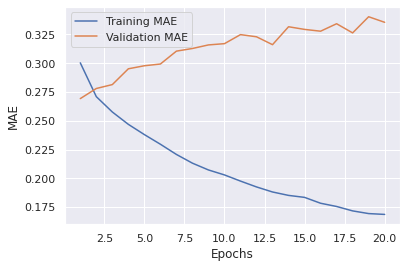

In [ ]:
plt.plot(epochs, train_mae2, label = 'Training MAE')
plt.plot(epochs, val_mae2, label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

We start overfitting from the begining. Let's evaluate our model2 on the test set.

In [ ]:
model2.evaluate(test_gen, steps=test_steps)

930/930 [==============================] - 12s 13ms/step - loss: 0.1980 - mae: 0.3476


[0.19802089035511017, 0.34757253527641296]

The test MAE is about 0.35, much better than before. This translates to a mean absolute error of 0.35 * 8.85 = 3.1˚C after de-normalization.  

## Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to.
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his [Ph.D. thesis](http://mlg.eng.cam.ac.uk/yarin/thesis/thesis.pdf) on
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's
more: in order to regularize the representations formed by the recurrent gates of layers such as LSTM, a temporally constant
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`,
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our LSTM layer and see how it impacts
overfitting.

In [ ]:
model3 = models.Sequential()
model3.add(layers.LSTM(32,
                      input_shape=(lookback // step, 14),
                      dropout=0.4,
                      recurrent_dropout=0.5))
model3.add(layers.Dense(1))

model3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model3_history = model3.fit(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 423s 846ms/step - loss: 0.1874 - mae: 0.3399 - val_loss: 0.1363 - val_mae: 0.2898
Epoch 2/20
500/500 [==============================] - 426s 852ms/step - loss: 0.1542 - mae: 0.3094 - val_loss: 0.1365 - val_mae: 0.2889
Epoch 3/20
500/500 [==============================] - 434s 868ms/step - loss: 0.1482 - mae: 0.3024 - val_loss: 0.1334 - val_mae: 0.2849
Epoch 4/20
500/500 [==============================] - 438s 877ms/step - loss: 0.1446 - mae: 0.2987 - val_loss: 0.1351 - val_mae: 0.2890
Epoch 5/20
500/500 [==============================] - 443s 885ms/step - loss: 0.1388 - mae: 0.2933 - val_loss: 0.1260 - val_mae: 0.2771
Epoch 6/20
500/500 [==============================] - 446s 892ms/step - loss: 0.1359 - mae: 0.2898 - val_loss: 0.1310 - val_mae: 0.2826
Epoch 7/20
500/500 [==============================] - 445s 890ms/step - loss: 0.1328 - mae: 0.2862 - val_loss: 0.1331 - val_mae: 0.2851
Epoch 8/20
500/500 [============================

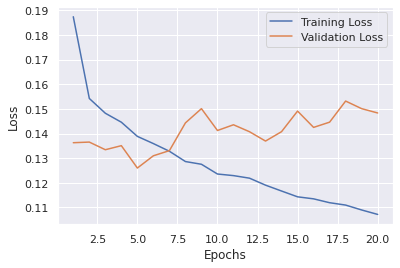

In [ ]:
import seaborn as sns
sns.set()

train_loss3 = model3_history.history['loss']
train_mae3 = model3_history.history['mae']
val_loss3 = model3_history.history['val_loss']
val_mae3 = model3_history.history['val_mae']

epochs = range(1, len(train_loss3) + 1)

plt.plot(epochs, train_loss3, label = 'Training Loss')
plt.plot(epochs, val_loss3, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

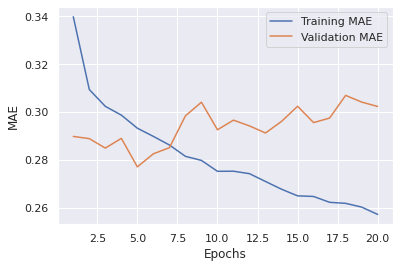

In [ ]:
plt.plot(epochs, train_mae3, label = 'Training MAE')
plt.plot(epochs, val_mae3, label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

We can see that including dropout and recurrent dropout has been helpful. We now overfit after 5 epochs.
Let's evaluate our model3 on the test set.

In [ ]:
model3.evaluate(test_gen, steps=test_steps)

930/930 [==============================] - 68s 73ms/step - loss: 0.1752 - mae: 0.3301


[0.17516912519931793, 0.3301335275173187]

The test MAE is about 0.33, slightly better than before. This translates to a mean absolute error of 0.33 * 8.85 = 2.9˚C after de-normalization.  

## Stacking LSTM layers

It is possible to stack multiple recurrent layers on top of each other to increase the representational power of our model. This sometimes helps, but may also result in more overfitting and a poorer performance.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs
rather than their output at the last timestep. This is done by specifying `return_sequences=True`. However, the last recurrent layer only needs to reurn its output at the last timestep (the default value for `return_sequences` is `False`).  

In [ ]:
model4 = models.Sequential()

model4.add(layers.LSTM(32, return_sequences=True,
                       input_shape=(lookback // step, 14)))
model4.add(layers.LSTM(32, return_sequences=True))
model4.add(layers.LSTM(32))

model4.add(layers.Dense(1))

model4.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model4_history = model4.fit(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 32s 64ms/step - loss: 0.1707 - mae: 0.3219 - val_loss: 0.1327 - val_mae: 0.2865
Epoch 2/20
500/500 [==============================] - 31s 63ms/step - loss: 0.1217 - mae: 0.2725 - val_loss: 0.1286 - val_mae: 0.2815
Epoch 3/20
500/500 [==============================] - 31s 62ms/step - loss: 0.1055 - mae: 0.2537 - val_loss: 0.1357 - val_mae: 0.2891
Epoch 4/20
500/500 [==============================] - 31s 62ms/step - loss: 0.0892 - mae: 0.2337 - val_loss: 0.1430 - val_mae: 0.2977
Epoch 5/20
500/500 [==============================] - 31s 63ms/step - loss: 0.0733 - mae: 0.2120 - val_loss: 0.1459 - val_mae: 0.2991
Epoch 6/20
500/500 [==============================] - 31s 62ms/step - loss: 0.0616 - mae: 0.1935 - val_loss: 0.1711 - val_mae: 0.3244
Epoch 7/20
500/500 [==============================] - 31s 62ms/step - loss: 0.0527 - mae: 0.1784 - val_loss: 0.1749 - val_mae: 0.3302
Epoch 8/20
500/500 [==============================] - 31s 62ms

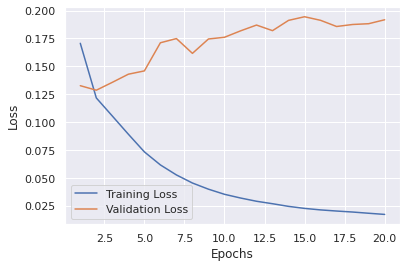

In [ ]:
import seaborn as sns
sns.set()

train_loss4 = model4_history.history['loss']
train_mae4 = model4_history.history['mae']
val_loss4 = model4_history.history['val_loss']
val_mae4 = model4_history.history['val_mae']

epochs = range(1, len(train_loss4) + 1)

plt.plot(epochs, train_loss4, label = 'Training Loss')
plt.plot(epochs, val_loss4, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

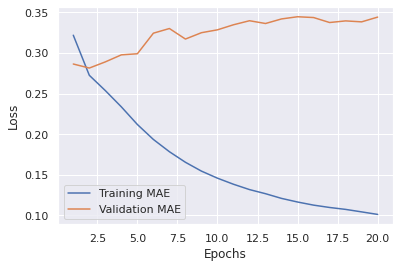

In [ ]:
plt.plot(epochs, train_mae4, label = 'Training MAE')
plt.plot(epochs, val_mae4, label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Let's evaluate our model4 on the test set.

In [ ]:
model4.evaluate(test_gen, steps=test_steps)

930/930 [==============================] - 18s 20ms/step - loss: 0.1928 - mae: 0.3474


[0.1928333044052124, 0.347369909286499]

The test MAE is about 0.35, which translates to a mean absolute error of 0.35 * 8.85 = 3.1˚C after de-normalization. In this example, stacking LSTM layers did not help, perhaps due to overfitting. We can include dropout arguments and see if the model performs any better. Feel free to try it yourself.